In [1]:
%load_ext autoreload
%autoreload 3
%load_ext nb_black
%load_ext dotenv
%dotenv
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

In [2]:
import os
import functools
import re
import pathlib

root = pathlib.Path(os.environ["DATA_ROOT"]).expanduser()

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import decimal

# import numba as nb
import plotnine as p9
import pandas as pd

import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf


%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
toprow_df = pd.read_csv("top-row-states.csv")
toprow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   speed    56 non-null     float64
 1   watts    56 non-null     int64  
 2   cadence  56 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


<IPython.core.display.Javascript object>

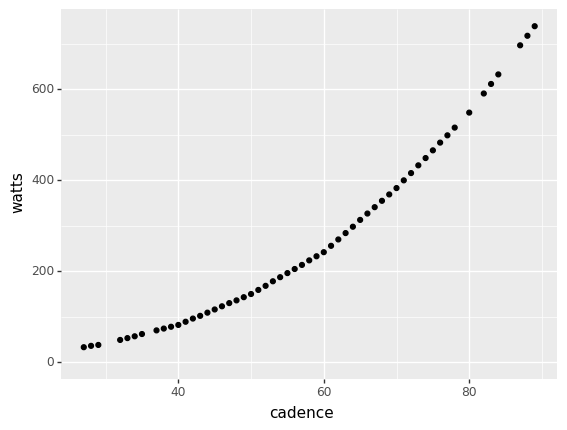

<ggplot: (8747500534268)>

<IPython.core.display.Javascript object>

In [10]:
p9.ggplot(toprow_df, p9.aes("cadence", "watts")) + p9.geom_point() + p9.ylim((0, None))

In [6]:
smf.ols("watts ~ cadence", toprow_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  watts   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     836.3
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           1.53e-34
Time:                        09:57:03   Log-Likelihood:                -296.58
No. Observations:                  56   AIC:                             597.2
Df Residuals:                      54   BIC:                             601.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -368.8483     23.112    -15.959      0.000    -415.186    -322.511
cadence       11.1235      0.385     28.919      0.000      10.352      11.895
==============================================================================
Omnibus:                        7.087   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.354
Skew:                           0.874   Prob(JB):                       0.0253
Kurtosis:                       2.691   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [11]:
smf.ols("watts ~ cadence + I(cadence ** 2)", toprow_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  watts   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.864e+04
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           9.51e-93
Time:                        10:05:06   Log-Likelihood:                -151.17
No. Observations:                  56   AIC:                             308.3
Df Residuals:                      53   BIC:                             314.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         143.6879      5.541     25.930      0.000     132.573     154.802
cadence            -8.2826      0.201    -41.145      0.000      -8.686      -7.879
I(cadence ** 2)     0.1677      0.002     97.414      0.000       0.164       0.171
==============================================================================
Omnibus:                        3.861   Durbin-Watson:                   0.182
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                3.530
Skew:                          -0.613   Prob(JB):                        0.171
Kurtosis:                       2.898   Cond. No.                     4.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

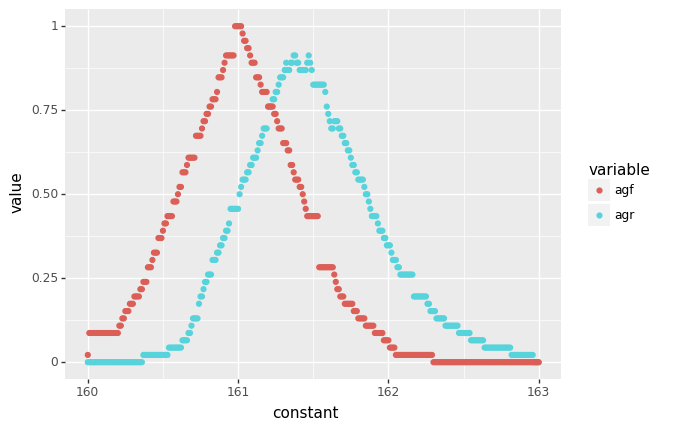

<ggplot: (8728736288189)>

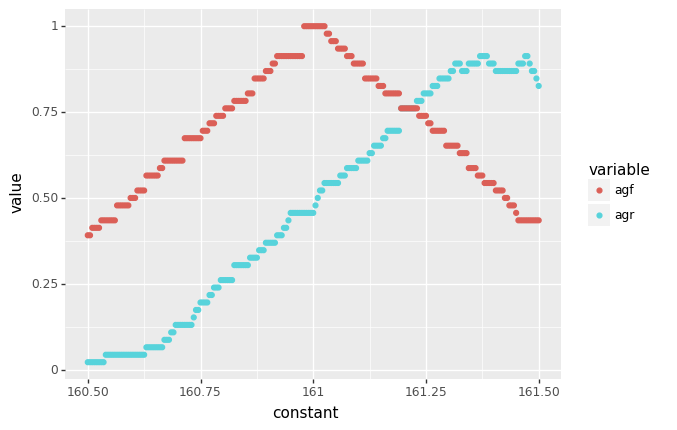

<ggplot: (8728736152075)>

<IPython.core.display.Javascript object>

In [5]:
toprow_df = pd.read_csv("top-row-states.csv")


# toprow_df.assign(revs_per_mile=lambda f: f.cadence * 60 / f.speed)
def round_with_mode(value, decimals, mode):
    with decimal.localcontext() as ctx:
        value_str = str(value)
        d = decimal.Decimal(value_str)
        ctx.rounding = mode
        return float(round(d, decimals))


step = 0.01
recs = []
for rv_mi in np.arange(160, 163 + step / 2, step):
    _df = toprow_df.assign(
        cspeed=lambda f: f.cadence * 60 / rv_mi,
        rspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_HALF_UP)
        ),
        fspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_DOWN)
        ),
        ragreement=lambda f: abs(f.speed - f.rspeed) < 1e-3,
        fagreement=lambda f: abs(f.speed - f.fspeed) < 1e-3,
    )
    rec = dict(constant=rv_mi, agr=_df.ragreement.mean(), agf=_df.fagreement.mean())
    recs.append(rec)

rdf = pd.DataFrame(recs)
(
    p9.ggplot(rdf.melt("constant"), p9.aes("constant", "value", color="variable"))
    + p9.geom_point()
)

step = 0.005
recs = []
for rv_mi in np.arange(160.5, 161.5 + step / 2, step):
    _df = toprow_df.assign(
        cspeed=lambda f: f.cadence * 60 / rv_mi,
        rspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_HALF_UP)
        ),
        fspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_DOWN)
        ),
        ragreement=lambda f: abs(f.speed - f.rspeed) < 1e-3,
        fagreement=lambda f: abs(f.speed - f.fspeed) < 1e-3,
    )
    rec = dict(constant=rv_mi, agr=_df.ragreement.mean(), agf=_df.fagreement.mean())
    recs.append(rec)

rdf = pd.DataFrame(recs)
(
    p9.ggplot(rdf.melt("constant"), p9.aes("constant", "value", color="variable"))
    + p9.geom_point()
)

In [7]:
revolutions_per_mile = 161
frames_per_second = 29.97  # ffprobe


# Conversion factors
alpha = 1 / revolutions_per_mile  # for converting revolutions to miles
gamma = 60  # for converting revolutions per second to revolutions per minute

# Initialize the Kalman filter
kf = KalmanFilter(dim_x=2, dim_z=2)

# Initialize the state with the first measurement
kf.x = np.array(
    [
        (rogue_df.dropna().iloc[0]["DISTANCE"]) / alpha,
        (rogue_df.dropna().iloc[0]["CADENCE"] + 0.5) / gamma,
    ]
)

# State transition matrix
kf.F = np.array(
    [
        [
            1,
            1 / frames_per_second,
        ],  # we are assuming the time difference between measurements is 1/30 second
        [0, 1],
    ]
)

# Measurement function
kf.H = np.array([[alpha, 0], [0, gamma]])

# Process noise covariance
df_diff = rogue_df[
    ["DISTANCE", "CADENCE"]
].diff()  # difference between consecutive measurements

# Convert units for DISTANCE (miles to revolutions) and CADENCE (revolutions/minute to revolutions/second)
df_diff["DISTANCE"] *= revolutions_per_mile  # alpha = 161 revolutions/mile
df_diff["CADENCE"] /= 60  # gamma = 1 revolution/second

Q_estimate = df_diff.var().values  # variance of the differences

# Set Q to the estimated values (on diagonal since we assume position and velocity are uncorrelated)
Q = np.diag(Q_estimate)

kf.Q = Q

# Measurement noise covariance
# Calculate variance of the measurements
R_estimate = rogue_df[["DISTANCE", "CADENCE"]].var().values

# Set R to the estimated values (on diagonal since we assume DISTANCE and CADENCE are uncorrelated)
R = np.diag(R_estimate)

kf.R = R * 2

# State covariance matrix
kf.P = np.eye(2)

zs = [
    None if np.isnan(v).any() else [v[0], v[1] + 0.5]
    for v in (e for (_, e) in rogue_df[["DISTANCE", "CADENCE"]].iterrows())
]


class HackedList(list):
    def __init__(self, *args):
        super().__init__(args)

    @property
    def shape(self):
        return [len(self)]


zs_wrapped = HackedList(*zs)


# Apply batch_filter method
mu, cov, _, _ = kf.batch_filter(zs_wrapped)
# mu, cov, _, _ = kf.rts_smoother(mu, cov)


# Store results
results = pd.DataFrame(mu, columns=["Estimated_Position", "Estimated_Velocity"])
results["Seconds"] = rogue_df.index / frames_per_second


results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estimated_Position  8077 non-null   float64
 1   Estimated_Velocity  8077 non-null   float64
 2   Seconds             8077 non-null   float64
dtypes: float64(3)
memory usage: 189.4 KB


<IPython.core.display.Javascript object>

/home/mike/.pyenv/versions/exercise-machina-3.10.11/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2953 rows containing missing values.


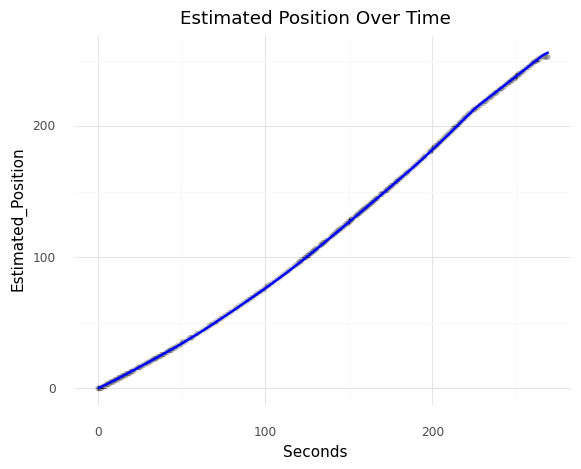

/home/mike/.pyenv/versions/exercise-machina-3.10.11/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 219 rows containing missing values.


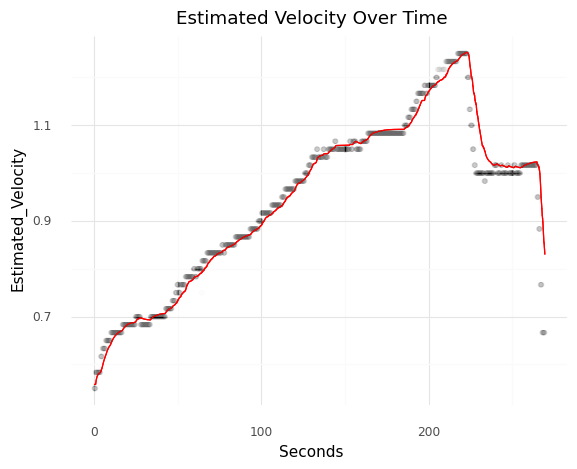

<IPython.core.display.Javascript object>

In [67]:
# Convert results to the correct datatypes
results['Estimated_Position'] = results['Estimated_Position'].astype(float)
results['Estimated_Velocity'] = results['Estimated_Velocity'].astype(float)

# Create position plot
position_plot = (
    p9.ggplot(results) +
    p9.aes(x='Seconds', y='Estimated_Position') +

    p9.ggtitle('Estimated Position Over Time') +
        p9.geom_point(data=rogue_df.assign(Seconds=lambda f: f.index/frames_per_second),
                  mapping=p9.aes(y="DISTANCE * revolutions_per_mile"),
                  alpha=0.01) +
     p9.geom_line(color='blue', size=1)    
    +     p9.theme_minimal()
)

# Create velocity plot
velocity_plot = (
    p9.ggplot(results) +
    p9.aes(x='Seconds', y='Estimated_Velocity') +
    p9.geom_line(color='red') +
    p9.ggtitle('Estimated Velocity Over Time') +
    p9.geom_point(data=rogue_df.assign(Seconds=lambda f: f.index/frames_per_second),
                  mapping=p9.aes(y="CADENCE/60"),
                  alpha=0.01) +  
        p9.geom_line(color='red') +
    p9.theme_minimal()
)

# Display the plots
print(position_plot)
print(velocity_plot)


In [ ]:
# Create Kalman filter object
kf_calories = KalmanFilter(dim_x=2, dim_z=1)

# State transition matrix (assuming constant velocity model)
kf_calories.F = np.array([[1.0, 1 / frames_per_second], [0.0, 1.0]])

# Measurement function (we only measure the "position", not the "velocity")
kf_calories.H = np.array([[1.0, 0.0]])

# Initial state
kf_calories.x = np.array([0.0, 0.0]).T  # start at 0 calories, 0 calories/sec

# Initial state covariance
kf_calories.P *= 10.0

# Process noise covariance (modify these values based on your data)
Q_cal_estimate = rogue_df["CALORIES"].diff().var()
kf_calories.Q = (
    Q_discrete_white_noise(dim=2, dt=1 / frames_per_second, var=Q_cal_estimate) * 10
)

# Measurement noise covariance (modify this value based on your data)
R_cal_estimate = rogue_df["CALORIES"].var()
kf_calories.R = np.array([[R_cal_estimate]]) * 10

# Prepare storage for filter output
results_calories = pd.DataFrame(
    columns=["time", "position", "velocity"], index=range(len(rogue_df))
)

# Run the Kalman filter on the data
for i, z in enumerate(rogue_df["CALORIES"].values):
    kf_calories.predict()
    if np.isnan(z):
        # If no measurement is available, only prediction step
        pass
    else:
        # If a measurement is available, use it for update
        kf_calories.update(np.array([z]))
    results_calories.iloc[i] = [
        i / frames_per_second,
        kf_calories.x[0],
        kf_calories.x[1],
    ]  # save estimated position and velocity

results_calories = results_calories.astype(float)

results_calories.info()

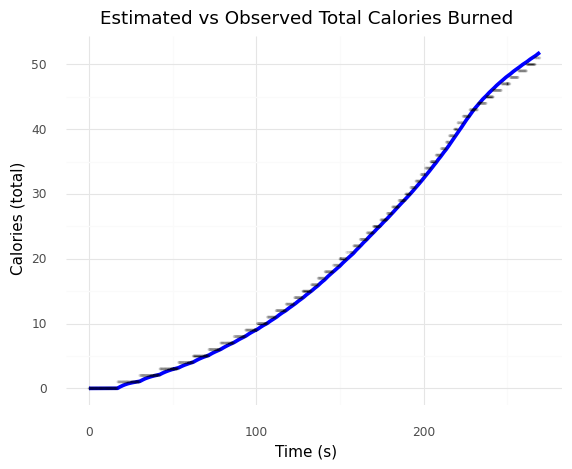

<ggplot: (8728733091027)>

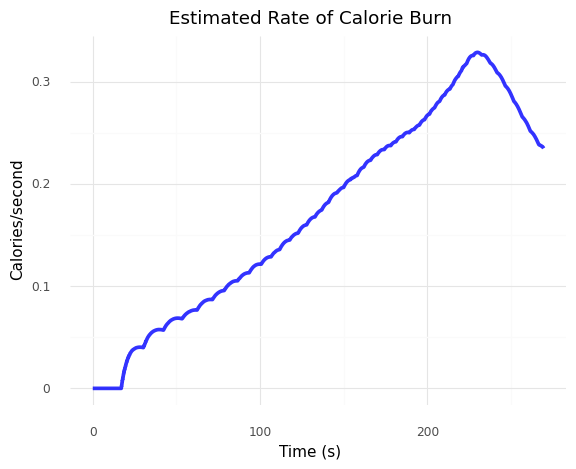

<ggplot: (8728733091255)>

<IPython.core.display.Javascript object>

In [11]:

# Plot estimated "position" (total calories burned) vs observed calories
(
    p9.ggplot() +
    p9.geom_line(data=results_calories, mapping=p9.aes(x='time', y='position'),
                 color='blue', size=1.5,  na_rm=True) +
    p9.geom_point(data=rogue_df.reset_index(), mapping=p9.aes(x='index/29.97', y='CALORIES'), color='black', size=0.5, alpha=0.01, na_rm=True) +
    p9.labs(x='Time (s)', y='Calories (total)', title='Estimated vs Observed Total Calories Burned') +
    p9.theme_minimal()
)

# Plot estimated "velocity" (rate of calorie burn)
(
    p9.ggplot() +
    p9.geom_line(data=results_calories, mapping=p9.aes(x='time', y='velocity'), color='blue', size=1.5, alpha=0.8, na_rm=True) +
    p9.labs(x='Time (s)', y='Calories/second', title='Estimated Rate of Calorie Burn') +
    p9.theme_minimal()
)



In [23]:
mdf = (
    results.merge(results_calories, left_on="Seconds", right_on="time")
    .rename(
        columns={
            "Estimated_Position": "revs",
            "Estimated_Velocity": "revs_per_second",
            "position": "cals",
            "velocity": "cals_per_second",
            "Seconds": "seconds",
        }
    )
    .drop(columns="time")
)
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   revs             8077 non-null   float64
 1   revs_per_second  8077 non-null   float64
 2   seconds          8077 non-null   float64
 3   cals             8077 non-null   float64
 4   cals_per_second  8077 non-null   float64
dtypes: float64(5)
memory usage: 315.6 KB


<IPython.core.display.Javascript object>

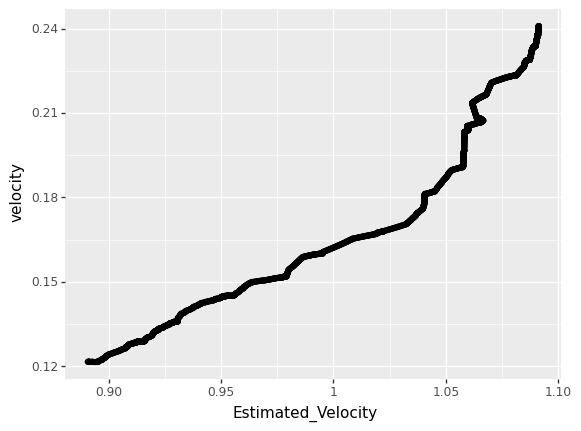

<ggplot: (8728732739458)>

<IPython.core.display.Javascript object>

In [19]:
(
    p9.ggplot(
        mdf.query("time.between(100, 180)"),
        p9.aes(x="Estimated_Velocity", y="velocity"),
    )
    + p9.geom_point()
)

<Axes: xlabel='seconds'>

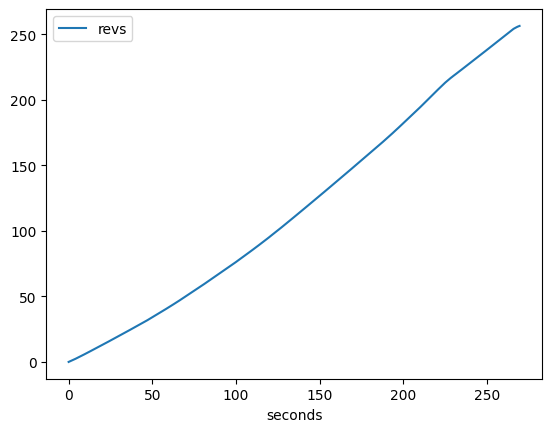

<IPython.core.display.Javascript object>

In [24]:
mdf.plot("seconds", "revs")

<Axes: xlabel='seconds'>

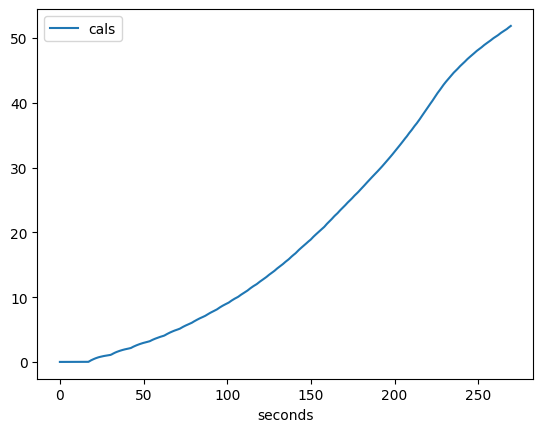

<IPython.core.display.Javascript object>

In [25]:
mdf.plot("seconds", "cals")

/home/mike/.pyenv/versions/exercise-machina-3.10.11/lib/python3.10/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/mike/.pyenv/versions/exercise-machina-3.10.11/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


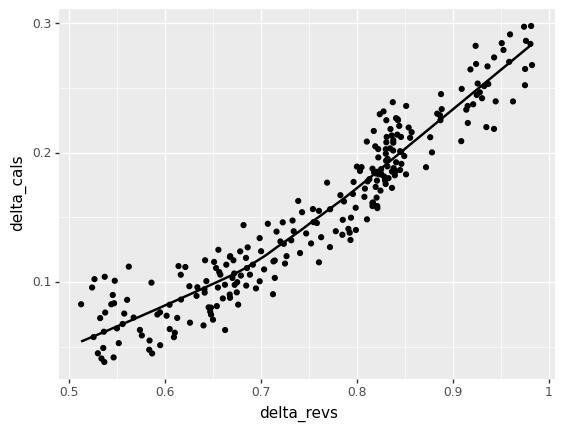

<ggplot: (8728732328738)>

<IPython.core.display.Javascript object>

In [45]:
n = 29
points = (
    mdf.query("seconds.between(30,220)")
    .iloc[::23]
    .assign(delta_revs=lambda f: f.revs.diff(), delta_cals=lambda f: f.cals.diff())
)

(
    p9.ggplot(points, p9.aes("delta_revs", "delta_cals"))
    + p9.geom_point()
    + p9.geom_smooth()
)

In [46]:
smf.ols("delta_cals ~ delta_revs", points).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             delta_cals   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2088.
Date:                Mon, 29 May 2023   Prob (F-statistic):          6.66e-122
Time:                        08:22:58   Log-Likelihood:                 605.35
No. Observations:                 247   AIC:                            -1207.
Df Residuals:                     245   BIC:                            -1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2208      0.008    -26.555      0.000      -0.237      -0.204
delta_revs     0.4968      0.011     45.700      0.000       0.475       0.518
==============================================================================
Omnibus:                        6.363   Durbin-Watson:                   0.810
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.544
Skew:                           0.393   Prob(JB):                       0.0379
Kurtosis:                       2.866   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [48]:
smf.ols("delta_cals ~ delta_revs + I(delta_revs ** 2)", points).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             delta_cals   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1327.
Date:                Mon, 29 May 2023   Prob (F-statistic):          7.75e-132
Time:                        08:23:01   Log-Likelihood:                 632.61
No. Observations:                 247   AIC:                            -1259.
Df Residuals:                     244   BIC:                            -1249.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1079      0.043      2.510      0.013       0.023       0.193
delta_revs            -0.4105      0.117     -3.500      0.001      -0.642      -0.179
I(delta_revs ** 2)     0.6091      0.078      7.762      0.000       0.455       0.764
==============================================================================
Omnibus:                        3.622   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.179
Skew:                           0.193   Prob(JB):                        0.204
Kurtosis:                       2.600   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [47]:
smf.ols(
    "delta_cals ~ delta_revs + I(delta_revs ** 2)+ I(delta_revs ** 3)", points
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             delta_cals   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     951.4
Date:                Mon, 29 May 2023   Prob (F-statistic):          5.96e-134
Time:                        08:22:58   Log-Likelihood:                 641.34
No. Observations:                 247   AIC:                            -1275.
Df Residuals:                     243   BIC:                            -1261.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1119      0.242      4.602      0.000       0.636       1.588
delta_revs            -4.5710      0.993     -4.605      0.000      -6.526      -2.616
I(delta_revs ** 2)     6.2427      1.338      4.667      0.000       3.608       8.877
I(delta_revs ** 3)    -2.4966      0.592     -4.219      0.000      -3.662      -1.331
==============================================================================
Omnibus:                        7.709   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                4.353
Skew:                           0.109   Prob(JB):                        0.113
Kurtosis:                       2.387   Cond. No.                     2.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [50]:
smf.ols(
    "delta_cals ~ delta_revs + I(delta_revs ** 2)+ I(delta_revs ** 3)+ I(delta_revs ** 3)",
    points,
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             delta_cals   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     951.4
Date:                Mon, 29 May 2023   Prob (F-statistic):          5.96e-134
Time:                        08:55:40   Log-Likelihood:                 641.34
No. Observations:                 247   AIC:                            -1275.
Df Residuals:                     243   BIC:                            -1261.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1119      0.242      4.602      0.000       0.636       1.588
delta_revs            -4.5710      0.993     -4.605      0.000      -6.526      -2.616
I(delta_revs ** 2)     6.2427      1.338      4.667      0.000       3.608       8.877
I(delta_revs ** 3)    -2.4966      0.592     -4.219      0.000      -3.662      -1.331
==============================================================================
Omnibus:                        7.709   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                4.353
Skew:                           0.109   Prob(JB):                        0.113
Kurtosis:                       2.387   Cond. No.                     2.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [49]:
smf.ols("np.log(delta_cals) ~ np.log(delta_revs)", points).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(delta_cals)   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1633.
Date:                Mon, 29 May 2023   Prob (F-statistic):          2.36e-110
Time:                        08:24:24   Log-Likelihood:                 87.259
No. Observations:                 247   AIC:                            -170.5
Df Residuals:                     245   BIC:                            -163.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2007      0.022    -54.812      0.000      -1.244      -1.158
np.log(delta_revs)     2.6066      0.064     40.414      0.000       2.480       2.734
==============================================================================
Omnibus:                       12.973   Durbin-Watson:                   0.703
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.932
Skew:                           0.122   Prob(JB):                     3.16e-07
Kurtosis:                       4.688   Cond. No.                         6.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>